## Music Genre Classification with PCA


```
Variable | Data Type | Description
Tempo | numerical | Beats per minute (BPM) of the track.
Dynamic Range | numerical | The range between the quietest and loudest parts of a track, typically measured in decibels (dB).
Vocal Presence | numerical | The prominence of vocals in a track.
Percussion Strength | numerical | the intensity and presence of percussion instruments in a track, such as drums or cymbals.
String Instrument Detection | numerical | The presence and prominence of string instruments like guitars, violins, or cellos in a track.
Electronic Element Presence | numerical | The intensity and presence of percussion instruments in a track, such as drums or cymbals.
Rhythm Complexity | numerical | The complexity and variation in a track's rhythm patterns, reflecting the intricacy of its beat and timing.
Drums Influence | numerical | The drums contribution to the overall sound of a track, focusing on their impact rather than just presence.
Distorted Guitar | numerical | The extent to which electronic sounds or synthesizers are used in a track.
Metal Frequencies | numerical | The use of distorted guitar sounds, often associated with genres like rock or metal.
Ambient Sound Influence | numerical | The use of ambient sounds in a track, which can add texture and atmospheric elements to the music.
Instrumental Overlaps | numerical | How different instruments interplay and overlap in a track, indicating the complexity of its instrumental arrangement.
Genre | categorical | The categorized genre of the track.
```

### Importing Libraries

In [79]:
import pandas as pd
import numpy as np
import scipy

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
df = pd.read_csv("/content/music_dataset_mod.csv")
df.head()

,Tempo,Dynamics Range,Vocal Presence,Percussion Strength,String Instrument Detection,Electronic Element Presence,Rhythm Complexity,Drums Influence,Distorted Guitar,Metal Frequencies,Ambient Sound Influence,Instrumental Overlaps,Genre
0,114.618354,57.976367,53.251766,99.061840,14.686768,17.628630,46.545522,75.839434,79.378892,71.753088,96.439665,53.771763,Country
1,116.672803,69.387087,95.787280,90.831033,47.280419,-15.618194,85.421085,100.455908,0.713015,0.000000,17.327295,15.017146,Classical
2,128.328121,52.930677,65.701187,104.439247,5.984994,50.467388,18.006722,77.642913,80.652946,87.692110,95.125207,25.308020,Rock
3,128.511337,25.494755,14.095374,40.106130,47.715584,87.335201,68.603329,63.536557,74.888346,76.239108,97.016998,96.893109,Hip-hop
4,135.474190,45.174876,101.469872,70.002203,108.177637,25.865590,31.295163,81.121030,36.178193,23.381542,53.753793,30.142986,Country


In [4]:
df.shape

(1000, 13)

Dataset consists of 1000 rows and 13 columns.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Tempo                        1000 non-null   float64
 1   Dynamics Range               1000 non-null   float64
 2   Vocal Presence               1000 non-null   float64
 3   Percussion Strength          1000 non-null   float64
 4   String Instrument Detection  1000 non-null   float64
 5   Electronic Element Presence  1000 non-null   float64
 6   Rhythm Complexity            1000 non-null   float64
 7   Drums Influence              1000 non-null   float64
 8   Distorted Guitar             1000 non-null   float64
 9   Metal Frequencies            1000 non-null   float64
 10  Ambient Sound Influence      1000 non-null   float64
 11  Instrumental Overlaps        1000 non-null   float64
 12  Genre                        890 non-null    object 
dtypes: float64(12), obj

In [6]:
df.describe()

,Tempo,Dynamics Range,Vocal Presence,Percussion Strength,String Instrument Detection,Electronic Element Presence,Rhythm Complexity,Drums Influence,Distorted Guitar,Metal Frequencies,Ambient Sound Influence,Instrumental Overlaps
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,121.177891,46.684324,51.741685,54.854619,58.442054,48.813244,54.421479,76.646294,47.462577,47.319735,50.858454,49.328441
std,19.600614,17.809545,29.008872,29.489650,29.650752,33.239190,29.606431,18.867990,32.492813,32.274932,29.419584,29.140840
min,50.494818,-4.165724,0.408370,0.598517,0.217449,-29.990605,0.146433,18.995222,0.047202,0.000000,0.008879,0.254396
25%,107.885045,34.252531,26.635663,29.782438,32.240968,22.331010,29.603967,62.916792,11.678634,14.422842,24.832718,23.605648
50%,121.356455,46.390854,52.245242,54.926936,59.366659,49.871999,54.618441,75.739758,52.994852,50.722858,52.400507,50.106840
75%,135.054584,58.481545,76.919814,79.438614,82.872727,75.133776,78.502328,89.973436,75.149865,75.673932,77.304355,75.550700
max,175.982637,104.932942,109.643123,114.949678,119.991892,119.728293,119.699889,140.031079,99.586429,100.000000,99.820903,99.958673


In [7]:
mising_val_cols = [features for features in df.columns if df[features].isnull().sum() > 0]
mising_val_cols

['Genre']

In [8]:
for col in mising_val_cols:
    missing_count = df[col].isnull().sum()
    total_count = len(df[col])
    missing_percent = (missing_count / total_count) * 100
    print(f"{col}: {missing_percent:.2f}% missing")

Genre: 11.00% missing


**Genre** is the only column with missing values, with **11%** of missing values.

In [9]:
df1 = df.copy()

<Axes: ylabel='Genre'>

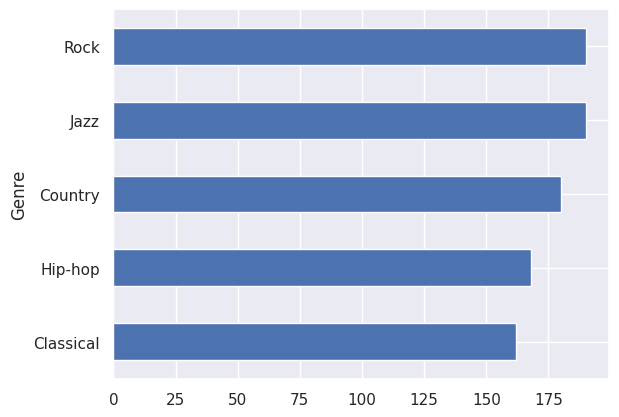

In [10]:
df1['Genre'].value_counts().sort_values(ascending=True).plot.barh()

There are total 5 music genres present in the dataset.

##### Correlation Heatmap

<Axes: >

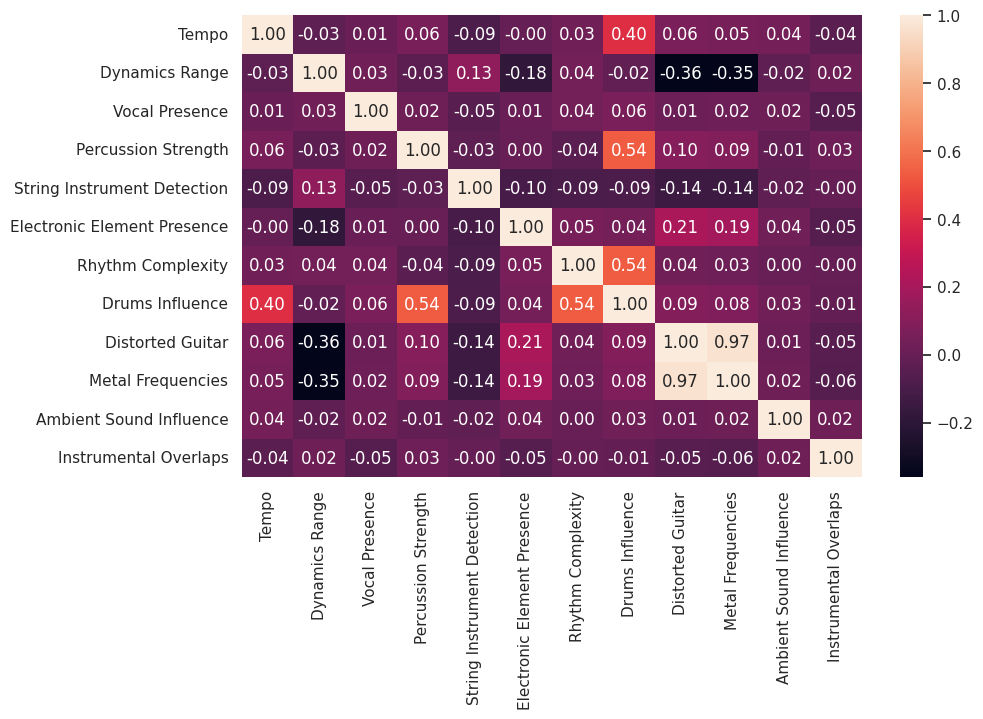

In [11]:
plt.figure(figsize=(10, 6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f")

**Distorted Guitar** & **Metal Frequencies** are both **correlated** with correlation of **0.97**.

##### Extracting missing values from Genre

into labelled and unlabelled datasets to use as train & test data.

In [12]:
df_labelled = df1[df1['Genre'].notna()].copy()

In [34]:
df_unlabelled = df1[df1['Genre'].isna()].copy()

In [14]:
print(df_labelled.shape, df_unlabelled.shape)

(890, 13) (110, 13)


In [35]:
df_unlabelled = df_unlabelled.drop(['Genre'], axis=1)

###### Label Encoding Genre Column

In [15]:
le = LabelEncoder()
df_labelled['Genre_encoded'] = le.fit_transform(df_labelled['Genre'])
le.classes_

array(['Classical', 'Country', 'Hip-hop', 'Jazz', 'Rock'], dtype=object)

###### Splitting data into train test

In [16]:
X = df_labelled.drop(['Genre', 'Genre_encoded'], axis=1)
y = df_labelled['Genre_encoded']

In [17]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_val.shape)

(712, 12) (178, 12)


In [18]:
scaler = StandardScaler()

In [19]:
X_scaled = scaler.fit_transform(X_train)

Performing PCA

In [20]:
pca = PCA().fit(X_scaled)

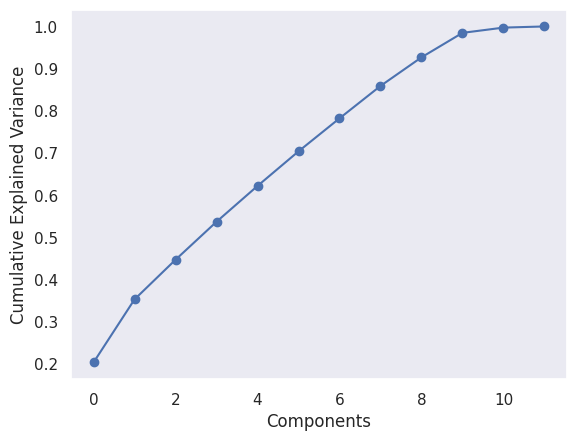

In [23]:
plt.plot(pca.explained_variance_ratio_.cumsum(), marker="o")
plt.xlabel("Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

In [24]:
pca.explained_variance_ratio_.cumsum()

array([0.20364028, 0.35313725, 0.4471005 , 0.53712036, 0.62198152,
       0.70397968, 0.78217653, 0.858979  , 0.92680066, 0.98480272,
       0.99725978, 1.        ])

In [50]:
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=8)),
    ('clf', LogisticRegression(
        solver="lbfgs",
        max_iter=1000,
        C=1,
        penalty='l2',
        random_state=42
    ) )
])

In [51]:
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=8)),
                ('clf',
                 LogisticRegression(C=1, max_iter=1000, random_state=42))])

In [52]:
y_pred = lr_pipeline.predict(X_val)

In [53]:
print("Validation Accuracy:", accuracy_score(y_val, y_pred))

Validation Accuracy: 0.5393258426966292


In [54]:
print("\nClassification Report:")
print(classification_report(y_val, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        32
           1       0.36      0.28      0.31        36
           2       0.43      0.44      0.43        34
           3       0.50      0.42      0.46        38
           4       0.53      0.63      0.58        38

    accuracy                           0.54       178
   macro avg       0.53      0.55      0.53       178
weighted avg       0.52      0.54      0.53       178



In [55]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Confusion Matrix:
[[31  0  1  0  0]
 [ 3 10  5  9  9]
 [ 1  5 15  4  9]
 [ 3  8  8 16  3]
 [ 0  5  6  3 24]]


**Class 0 (Classical)** is very well predicted.

**Classes 2 (Hip-hop) 3 (Jazz) and 4 (Rock)** show moderate accuracy.

**Class 1 (Country)** is the hardest — features overlap with others.

In [37]:
models = {
    "Logistic Regression": LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM (RBF)": SVC(kernel='rbf')
}

In [38]:
results = {}

for name, model in models.items():
  comb_pipe = Pipeline([
      ("scaler", StandardScaler()),
      ("pca", PCA(n_components=8)),
      ("clf", model)
  ])

  cv_scores = cross_val_score(comb_pipe, X, y, cv=5, scoring="accuracy")
  results[name] = (cv_scores.mean(), cv_scores.std())

In [39]:
for model_name, (mean_acc, std_acc) in results.items():
    print(f"{model_name}: Mean Acc = {mean_acc:.4f}, Std = {std_acc:.4f}")

Logistic Regression: Mean Acc = 0.5360, Std = 0.0215
KNN: Mean Acc = 0.4517, Std = 0.0250
SVM (RBF): Mean Acc = 0.5270, Std = 0.0345


### HyperParameter Tuning

In [80]:
param_grid_lr = {
    "clf__C": [0.01, 0.1, 1, 5, 10, 50],
    "clf__penalty": ['l2'],
    "clf__solver": ['lbfgs', 'saga'],
    "clf__max_iter": [2000]
}

In [82]:
grid_lr = GridSearchCV(lr_pipeline, param_grid_lr, cv=5, scoring='accuracy')

In [83]:
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=30. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA(n_components=8)),
                                             ('clf',
                                              LogisticRegression(C=1,
                                                                 max_iter=1000,
                                                                 random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'clf__C': [0.01, 0.1, 1, 5, 10, 50],
                                        'clf__max_iter': [2000],
                                        'clf__penalty': ['l2'],
                                        'clf__solver': ['lbfgs', 'saga']},
                   random_state=42, scoring='accuracy', verbose=2)

In [84]:
print("Best Logistic Regression params:", grid_lr.best_params_)
print("Best LR CV Accuracy:", grid_lr.best_score_)

Best Logistic Regression params: {'clf__solver': 'lbfgs', 'clf__penalty': 'l2', 'clf__max_iter': 2000, 'clf__C': 1}
Best LR CV Accuracy: 0.5434846843297547


In [62]:
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=8)),
    ("knn", KNeighborsClassifier())
])

In [63]:
param_grid_knn = {
    "knn__n_neighbors": [3, 5, 7, 9, 11, 15],
    "knn__weights": ['uniform', 'distance'],
    "knn__metric": ['euclidean', 'manhattan']
}

In [64]:
grid_knn = GridSearchCV(knn_pipeline, param_grid_knn, cv=5, scoring='accuracy')

In [66]:
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=8)),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['euclidean', 'manhattan'],
                         'knn__n_neighbors': [3, 5, 7, 9, 11, 15],
                         'knn__weights': ['uniform', 'distance']},
             scoring='accuracy')

In [67]:
print("Best KNN params:", grid_knn.best_params_)
print("Best KNN CV Accuracy:", grid_knn.best_score_)

Best KNN params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 15, 'knn__weights': 'distance'}
Best KNN CV Accuracy: 0.48597458879149025


In [68]:
svc_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=8)),
    ("svm", SVC())
])

In [69]:
param_grid_svc = {
    "svm__C": [0.1, 1, 5, 10, 20],
    "svm__gamma": ['scale', 'auto', 0.01, 0.05, 0.1, 0.2],
    "svm__kernel": ['rbf']
}

In [70]:
grid_svm = GridSearchCV(svc_pipeline, param_grid_svc, cv=5, scoring='accuracy')

In [71]:
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=8)),
                                       ('svm', SVC())]),
             param_grid={'svm__C': [0.1, 1, 5, 10, 20],
                         'svm__gamma': ['scale', 'auto', 0.01, 0.05, 0.1, 0.2],
                         'svm__kernel': ['rbf']},
             scoring='accuracy')

In [72]:
print("Best SVM params:", grid_svm.best_params_)
print("Best SVM CV Accuracy:", grid_svm.best_score_)

Best SVM params: {'svm__C': 1, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Best SVM CV Accuracy: 0.5434846843297547


In [73]:
best_lr_model = grid_lr.best_estimator_

In [74]:
y_pred = best_lr_model.predict(X_val)

In [75]:
print("Test Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Test Accuracy: 0.5393258426966292
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89        32
           1       0.36      0.28      0.31        36
           2       0.43      0.44      0.43        34
           3       0.50      0.42      0.46        38
           4       0.53      0.63      0.58        38

    accuracy                           0.54       178
   macro avg       0.53      0.55      0.53       178
weighted avg       0.52      0.54      0.53       178

Confusion Matrix:
 [[31  0  1  0  0]
 [ 3 10  5  9  9]
 [ 1  5 15  4  9]
 [ 3  8  8 16  3]
 [ 0  5  6  3 24]]


In [76]:
best_svm_model = grid_svm.best_estimator_

In [77]:
y_pred = best_svm_model.predict(X_val)

In [78]:
print("Test Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Test Accuracy: 0.5561797752808989
Classification Report:
               precision    recall  f1-score   support

           0       0.76      1.00      0.86        32
           1       0.45      0.25      0.32        36
           2       0.44      0.35      0.39        34
           3       0.53      0.45      0.49        38
           4       0.51      0.76      0.61        38

    accuracy                           0.56       178
   macro avg       0.54      0.56      0.54       178
weighted avg       0.53      0.56      0.53       178

Confusion Matrix:
 [[32  0  0  0  0]
 [ 4  9  5  7 11]
 [ 2  4 12  4 12]
 [ 4  5  7 17  5]
 [ 0  2  3  4 29]]


#### Training on full labelled data

In [93]:
best_svm_model.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=8)),
                ('svm', SVC(C=1, gamma=0.01))])

In [94]:
predicted_genres = best_svm_model.predict(df_unlabelled)

In [97]:
predicted_og_genre = le.inverse_transform(predicted_genres)

In [98]:
df_unlabelled['Genre'] = predicted_og_genre

In [99]:
df_unlabelled.head(5)

,Tempo,Dynamics Range,Vocal Presence,Percussion Strength,String Instrument Detection,Electronic Element Presence,Rhythm Complexity,Drums Influence,Distorted Guitar,Metal Frequencies,Ambient Sound Influence,Instrumental Overlaps,Genre
13,104.389822,65.826509,45.855410,55.655533,76.058845,55.625315,25.312585,59.202818,0.920308,0.000000,94.308889,27.441046,Classical
18,101.367152,47.843370,93.230347,67.101777,20.932163,50.772288,30.348312,62.950165,64.462755,68.971944,21.690071,94.717315,Country
22,85.130539,55.707108,81.149615,21.473425,14.959208,61.017283,64.000152,43.332846,70.455879,79.053598,20.420619,99.499498,Jazz
31,121.100952,71.769727,49.609529,82.539647,47.670106,119.460607,68.812707,83.727876,95.307620,95.779062,2.883916,19.230684,Rock
42,93.546825,44.563761,56.587554,99.546134,109.735122,30.128106,48.392807,81.888793,97.200948,100.000000,16.380240,55.483399,Rock
